In [2]:
# load packages
import numpy as np 
import scipy 
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
import mne
from mne.viz import plot_topomap
from mne.io import RawArray
import numpy.matlib
sns.set_theme() # set the plotting atmosphere

In [96]:
# montage info 
montageIn = mne.channels.make_standard_montage("GSN-HydroCel-128")
info = mne.create_info(ch_names=montageIn.ch_names, sfreq=1, ch_types="eeg")
info.set_montage(montageIn)
print(montageIn)

contrast_levels=np.array([1, 3, 5, 16, 40, 100])
cll=['1%', '3%', '5%', '16%', '40%', '100%']
ttl = ['2f1','4f1','6f1','8f1','2f2','4f2','6f2','8f2']

elec_Arc1_outer = [68,64,58,51,47,42,37,31,    80,87,93,98,97,96,95,94]
elec_Arc2 = [73,69,65,59,52,53,54,  55,  79,86,92,91,90,89,88]
elec_Arc3 = [74,70,66,60,61,  78,85,84,83,82,  81]
elec_Arc4_inner = [71,67,62,77,76,75,     72]
AllAnalysisChans = np.concatenate([elec_Arc1_outer,elec_Arc2,elec_Arc3,elec_Arc4_inner])
#AllAnalysisChans = np.concatenate([elec_Arc2,elec_Arc3,elec_Arc4_inner])
AnalysisChans = np.unique(AllAnalysisChans) - 1
VisChans = np.sort(AnalysisChans)
print(f'Channels to be visualized: {VisChans}')
ch_list = np.arange(0,NumChans,1)
ocm = np.zeros_like((ch_list))
ocm[VisChans] = True # set good chans to true
ocm_chans = ocm.astype(bool)

def init_TopoTemplate(title_In):
    """Prep topo plot fig and axes"""
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4)) # ,gridspec_kw=dict(height_ratios=[3]), layout = 'constrained'
    axes[0].axis('off')
    axes[1].axis('off')
    axes[0].gridspec_kw=dict(height_ratios=[3])
    axes[1].gridspec_kw=dict(height_ratios=[3])
    plt.tight_layout()
    plt.suptitle(f'{title_In}', fontsize = 20)
    #axes[0].set_title(f'{title_In}', fontsize = 20)
    #axes[1].set_title(f'{title_In}', fontsize = 20)
    return fig, axes


<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 128 channels>
Channels to be visualized: [30 36 41 46 50 51 52 53 54 57 58 59 60 61 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97]


### Import all files that will be sorted and exported into another .mat file

In [3]:
# Main Directory of processed file from MatLab
#MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir
MainDir = 'C:\\plimon\\LTP_analysis\\eegMatFiles\\MAT' # set dir
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Number of Files on hand: {int(len(d))}')
##############################################
FileN = d[10] # choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
#print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Number of Files on hand: 50
Current WD: C:\plimon\LTP_analysis\eegMatFiles\MAT\nl-2666_attnL_20231023_1612_RLS.mat


In [97]:
NumHarms = 4
NumBins = 6
allbins = 7 # 6 contrasts + prelude bin
NumHemis = 2
co = 0

ExpectedRows = (8*allbins)* 2
BadRows = (9*allbins)*2
print(ExpectedRows, BadRows)

GoodDataDims = NumHarms*NumBins*NumHemis
GoodKeyDicts = NumHarms*NumHemis
print(GoodDataDims,GoodKeyDicts) # rows after data has been cleaned
Fnames = np.sort(d)

112 126
48 8


In [45]:
b = np.array(np.arange(0,allbins,1))
h = np.arange(0,8,1)
hi = np.tile(h,7)
hIters = np.array(np.sort(hi))
print(hIters)

[0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 4 4 4 4 4 4 4 5 5
 5 5 5 5 5 6 6 6 6 6 6 6 7 7 7 7 7 7 7]


In [87]:
SignalData  = {} # ave average data 
RealnImaginaryData = {} # save real and imaginary data 

for suIn in range(1):#range(10):# og d 
    RealnImaginaryData[suIn] = {}
### import file path 
    FileN = Fnames[suIn] # import from sorted subj expt name list                       
    file_path = os.path.join(MainDir, FileN) # join paths and prep 2 load
    mat_data = scipy.io.loadmat(file_path) # import data file
    # extract from file 
    MainData = mat_data['signalData'][co][0]
    # set nans
    SortDataIn = np.array(MainData)
    [NumRows, NumChans, NumTrials] = SortDataIn.shape # get dims of data to use later ..
    real_imag_bound = int((NumRows/2))
    #print(f'Data real-imag bound is at row: #{real_imag_bound}')
    chanInd = np.arange(1,NumChans,1)
    prepost_bound = int(NumTrials/2)
### reshape real and imaginary values and remove 0's with nan's
    dIn = SortDataIn.reshape(real_imag_bound,2,NumChans,NumTrials,order='A')
    # RealnImaginaryData[suIn]= dIn    
    dIn[dIn==0]=np.nan
    print(dIn.shape)
    RowCount = int(dIn.shape[0])
    if RowCount == int(ExpectedRows/2): # if data dont have extra f1 data
        print(f'data is expected shape')
        data = dIn
    else:
        print(f'data contains f1 info') # data has extra f1 info - rmv
        data = dIn[allbins:,:,:] # remove 0-7 rows
        print(f'f2 data removed, new shape {data.shape}')

    xF_Bins = {}
    for hi in range(8):
        tempIn =data[hIters == hi]
        tempOut = tempIn[1:,:,:,:]
        #print(tempOut.shape)
        xF_Bins[hi] = tempOut

    tInds = np.arange(0,NumTrials,prepost_bound)# trial inds

    sOut = {} # hypot data
    # riOut = {} # real / imaginary data

    valMat = np.zeros((8,2,6,128))
    for fritter in range(8): # per frequency 
        fIn = xF_Bins[fritter]
        #print(fIn.shape)
        for triters in range(2): # per trial
            ti = tInds[triters]
            te = ti + prepost_bound
            ppIn = fIn[:,:,:,ti:te]
            for biters in range(6): # per bin
                bdIn = ppIn[biters,:,:,:]
                for chiters in range(128): # per channel
                    chIn = bdIn[:,chiters,:] # 2 x 29 (real /imag) x trials
                    preChAct = np.nanmean(bdIn[0,chiters,:]) # 39 rela and imaginary vals per bin x chan x harmonic x hemifield
                    postChAct = np.nanmean(bdIn[1,chiters,:])
                    hypOut = np.hypot(preChAct,postChAct)
                    valMat[fritter,triters,biters,chiters] = hypOut
                    #print(preChAct,postChAct, hypOut)
print(valMat.shape)

(63, 2, 128, 78)
data contains f1 info
f2 data removed, new shape (56, 2, 128, 78)
(8, 2, 6, 128)


In [100]:
t_F1  = valMat[0,:,:,:] # harmonicHemi x prepost x bins x channels
t_F2 = valMat[4,:,:,:]
print(t_F1.shape) # pre post for contrat allchannels

(2, 6, 128)


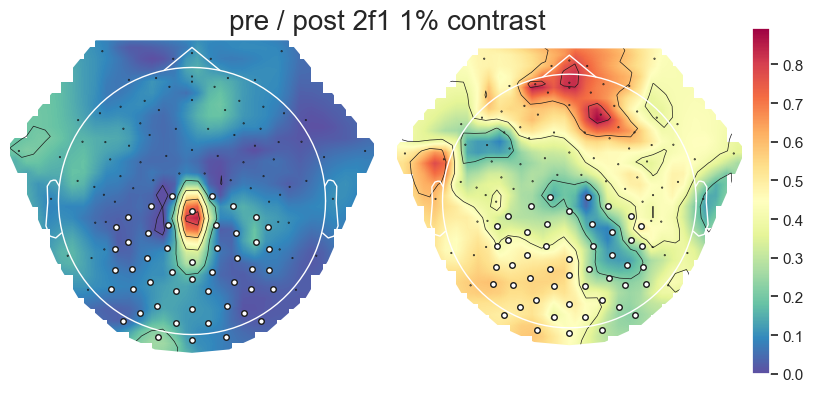

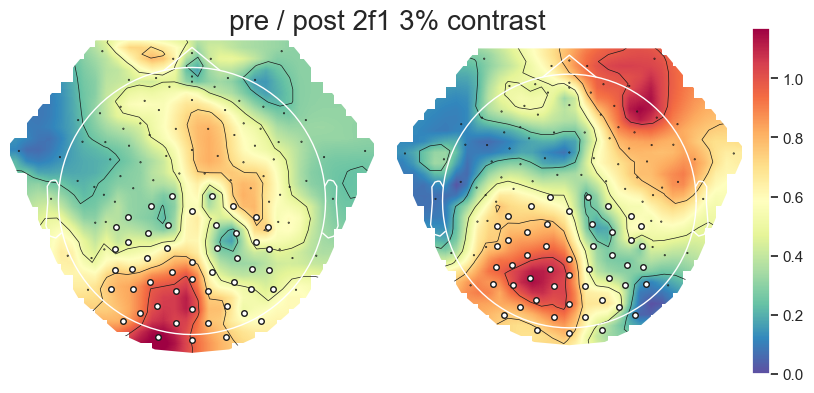

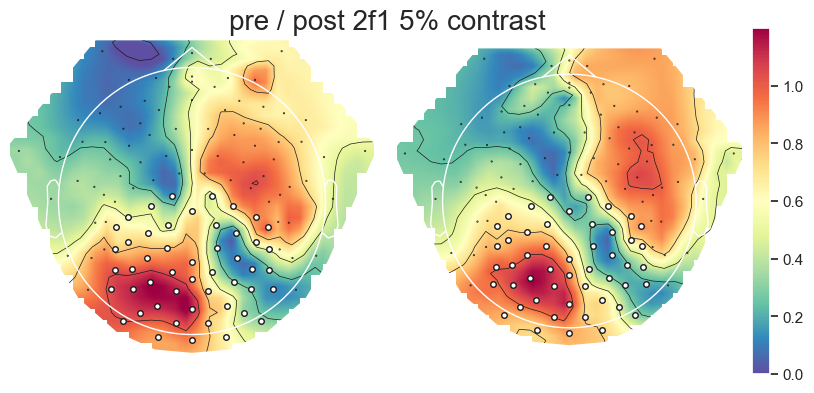

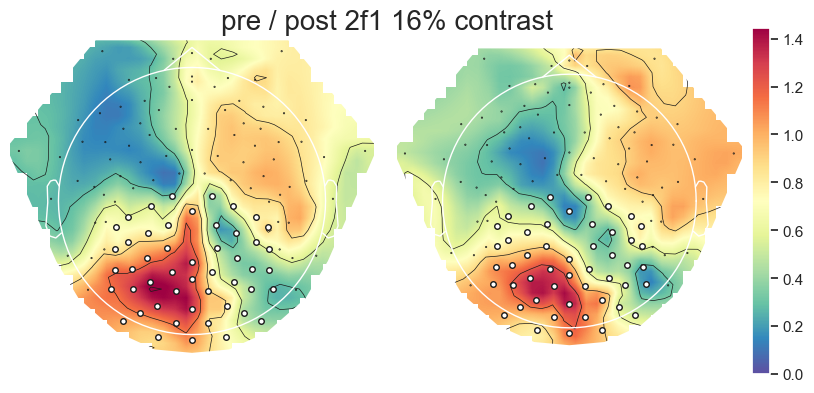

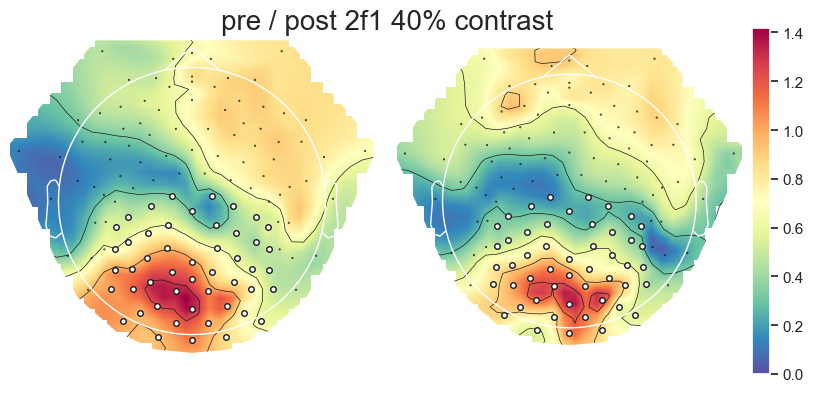

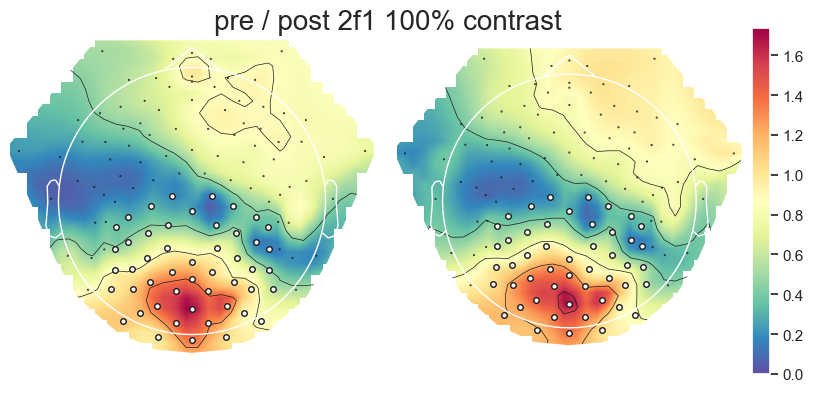

In [104]:
for bin in range(6):
    tIn_pre = t_F1[0,bin,:]
    tIn_post = t_F1[1,bin,:]
    # findLims = np.vstack((tIn_F1,tIn_F2))
    # print(findLims.shape)
    # t_max = np.max(findLims)
    # t_min = np.min(findLims)
    # print(t_min,t_max)
    v_max = 3
    v_min = 0

    fig, axes = init_TopoTemplate(f'pre / post 2f1 {cll[bin]} contrast')
    # left side plot
    im,_ = plot_topomap(tIn_pre, info,mask = ocm, axes = axes[0], show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
    # middle  plot
    im,_ = plot_topomap(tIn_post, info,mask = ocm, axes = axes[1],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')

    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = plt.colorbar(im, cax=cax)

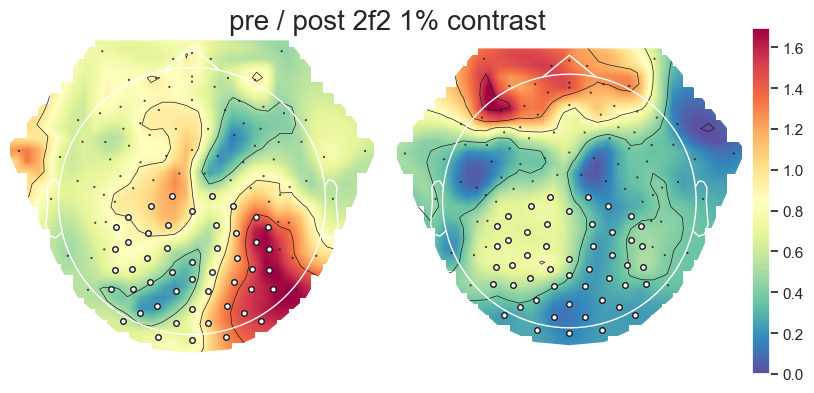

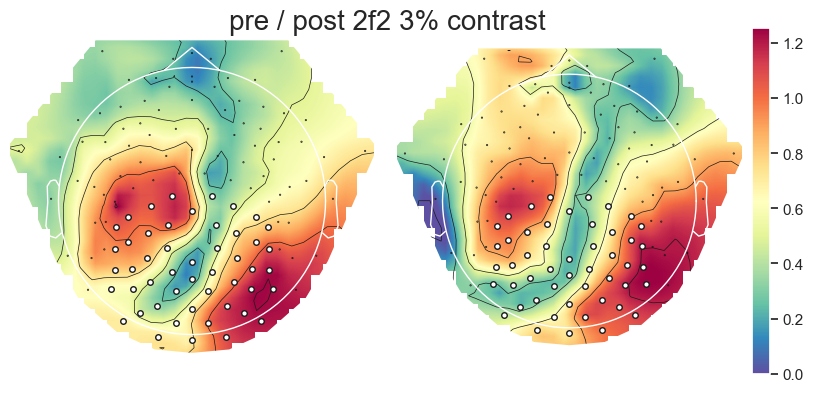

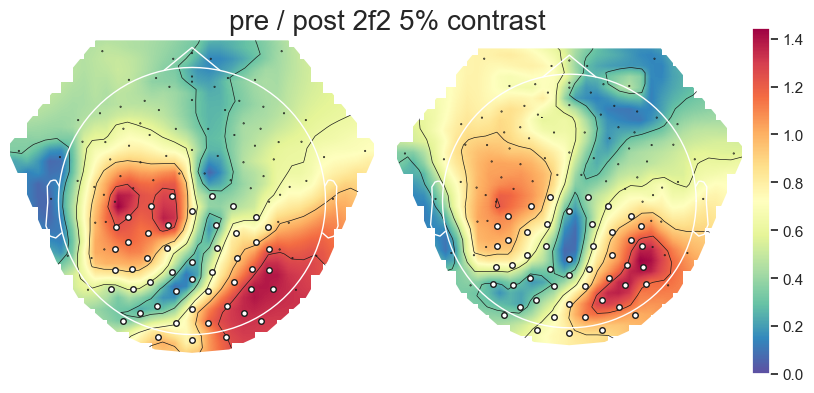

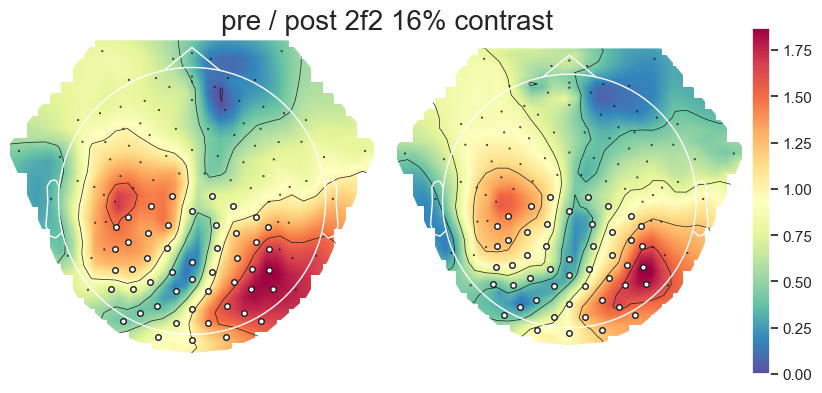

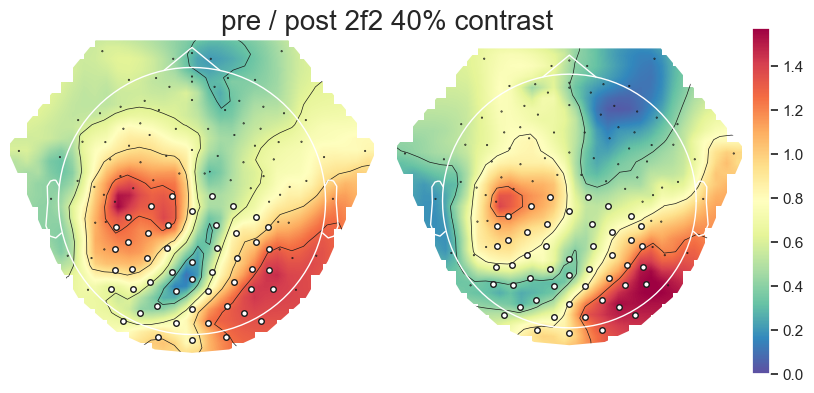

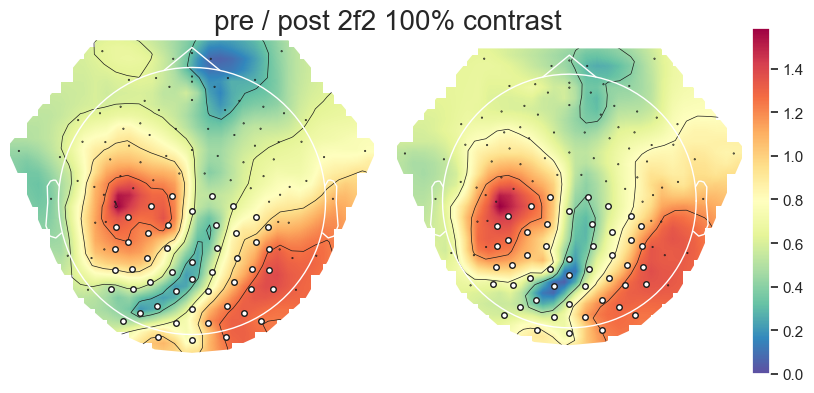

In [103]:
for bin in range(6):
    tIn_pre = t_F2[0,bin,:]
    tIn_post = t_F2[1,bin,:]
    # findLims = np.vstack((tIn_F1,tIn_F2))
    # print(findLims.shape)
    # t_max = np.max(findLims)
    # t_min = np.min(findLims)
    # print(t_min,t_max)
    v_max = 3
    v_min = 0

    fig, axes = init_TopoTemplate(f'pre / post 2f2 {cll[bin]} contrast')
    # left side plot
    im,_ = plot_topomap(tIn_pre, info,mask = ocm, axes = axes[0], show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
    # middle  plot
    im,_ = plot_topomap(tIn_post, info,mask = ocm, axes = axes[1],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')

    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = plt.colorbar(im, cax=cax)

## dont touch!!! until above is resolved

In [ ]:
print(RealnImaginaryData.keys())
print(RealnImaginaryData[0].keys())
print(RealnImaginaryData[0][0].shape)

In [ ]:
# sIn = 25

# fig,axs = plt.subplots(8,2, figsize = (4,16), sharey = True)
# d2p = SignalData[sIn]
# print(d2p.keys())

# for i in range(8):
#     #print(d2p[i].shape)
#     axs[i,0].plot(d2p[i][:,0,55:90])
#     axs[i,1].plot(d2p[i][:,1,55:90])


#### Sort Condition Bools

In [ ]:
FileNamesIndicies = np.array(d) # make list into array 
FileName = [FileNamesIndicies.replace('_','-') for FileNamesIndicies in FileNamesIndicies] # uniform fnames to make bools for attnl and attnR 

In [ ]:
DataOut = {}

DataOut['RealImaginaryData_sIns'] = RealnImaginaryData
DataOut['EEGData'] = SignalData
DataOut['SubIDs'] = FileName

In [ ]:
SaveDataDir = 'C:\\plimon\\LTP_analysis\\eegMatFiles\\AllMat'
print(os.path.exists(SaveDataDir)) # does pth exist :p

dnt = datetime.now() # add date and time bc im wreckless when saving ..
fdnt = dnt.strftime("%Y%m%d_%H%M%S") # set the above as a string ...
FileOutName = 'AllSubj_MatFiles_ri_C1'
FileN = f'{FileOutName}_{fdnt}.pkl' 
NewFileNPath = os.path.join(SaveDataDir,FileN)
print('Full New File Dir: ', NewFileNPath)

saveFile = 'y'
if saveFile == 'y':
 with open(NewFileNPath, 'wb') as file:
    pkl.dump(DataOut, file, protocol=pkl.HIGHEST_PROTOCOL)
    print('MAT Data For All Subjs Saved! :))')
else:
    print('Did Not Save File! Change file name before switching to y!')

#### Index certain keys for analysis and conditions during expt

In [ ]:
# # find basic data parms 
# MainData = mat_data['signalData']
# noise1 = mat_data['noise1'] # 6 x 1 
# noise2 = mat_data['noise2']
# inds = mat_data['info'][0][0]
# ExpConds = int(MainData.shape[0])
# print(f'Data file contains data for {ExpConds} different conditions')

In [ ]:
# elec_Arc1_outer = [68,64,58,51,47,42,37,31,    80,87,93,98,97,96,95,94]
# elec_Arc2 = [73,69,65,59,52,53,54,  55,  79,86,92,91,90,89,88]
# elec_Arc3 = [74,70,66,60,61,  78,85,84,83,82,  81]
# elec_Arc4_inner = [71,67,62,77,76,75,     72]
# AllAnalysisChans = np.concatenate([elec_Arc1_outer,elec_Arc2,elec_Arc3,elec_Arc4_inner])
# #AllAnalysisChans = np.concatenate([elec_Arc2,elec_Arc3,elec_Arc4_inner])
# AnalysisChans = np.unique(AllAnalysisChans)
# AnalysisChans_int = np.array(AnalysisChans, dtype = int)
# VisChans = np.sort(AnalysisChans)

#### Make Bool mask for mne topoplots

In [ ]:
# OcciMask = np.zeros((128), dtype = bool) # mask of len nchans
# OcciMask[VisChans] = True # set good chans to true 
# #print(OcciMask)

In [ ]:
# # save signal data
# FreqDataPerCo = {}
# for co in range(ExpConds):
#     #print(MainData[co][0].shape)
#     FreqDataPerCo[co] = MainData[co][0]
# # noise data 1 
# Noise1DataPerCo = {}
# for co in range(ExpConds):
#     #print(noise1[co][0].shape)
#     Noise1DataPerCo[co] = noise1[co][0]
# # noise data 2
# Noise2DataPerCo = {}
# for co in range(ExpConds):
#     #print(noise2[co][0].shape)
#     Noise2DataPerCo[co] = noise2[co][0]

In [ ]:
# co = 0 # pre and post induction ltp
# HarmInd = np.ravel(mat_data['info'][0][0] [0][co][0])
# BinInd = np.ravel(mat_data['info'][0][0] [1][co][0])
# #HarmonLabels = mat_data['info'][0][0][2][co][0]
# AvgAct = mat_data['info'][0][0] [3][co] [0] # returns an array with 6 values ...
# NumCondInd = mat_data['info'][0][0][4][co][0] # bin index, includes preludes
# HemiFieldLabels = mat_data['info'][0][0] [2][co][0] # contains harmonic and hemifield data
# hemiFieldnHarmonicInd = mat_data['info'][0][0] [2][co] [0]
#########IN case some nexted arrays need to be extracted or explored
# co = 0
# ind = 2
# inds = mat_data['info'][0][0] [ind][co] [0] # avoid prelude bind which == 0 actually 
# #print(inds)
# for innerlist in inds:
#     for item in innerlist:
#        print(item)
# HemiBound = int(int(len(HemiFieldLabels))/2)
# print(HemiBound) # index for Fx filter freq